# CSC 219 - Final Project
## Image Classification with Fashion-MNIST and CIFAR-10
### Khoi Hoang

# Abstract
There are many different technique and models to solve the problem of image classification.  
It is important for students to fully understand the principles behind each model and its performance based on the dataset.  
The purpose of this project is to gain a deeper understanding of different classification models, and how they perform on the Fashion-MNIST and CIFAR-10 dataset.  

In [1]:
import collections
from sklearn import preprocessing
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Helper function
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Print markdown style
def printmd(string):
    display(Markdown(string))

# Fashion-MNIST dataset

The following information is taken from Keras website: https://keras.io/datasets/  
The Fashion-MNIST dataset consists of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images.  
The class labels for the data are:

| Label | Description | 
| --- | --- | 
| 0 | T-shirt/Top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle Boot |

In [38]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of y_train: {}".format(y_train.shape))
print()
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (60000, 28, 28)
Shape of y_train: (60000,)

Shape of x_test: (10000, 28, 28)
Shape of y_test: (10000,)


Image (#79): Which is label number '9', or label 'Ankle boot''


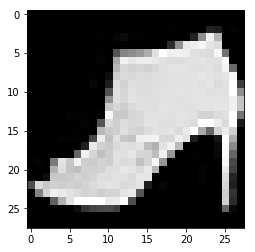

In [39]:
labelNames = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
sample = 79 
digit = x_train[sample]

plt.imshow(digit, cmap='gray')
print("Image (#{}): Which is label number '{}', or label '{}''".format(sample,y_train[sample], labelNames[y_train[sample]]))

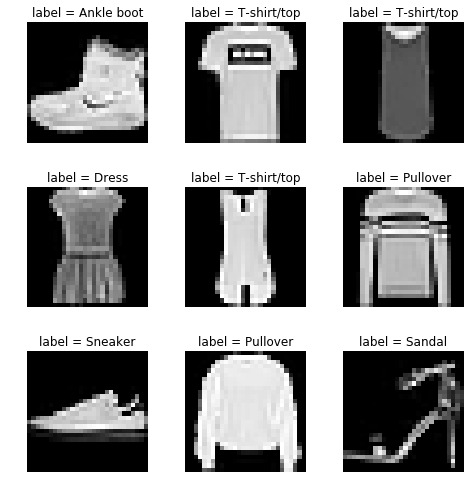

In [41]:
ROW = 3
COLUMN = 3
plt.figure(figsize=(7, 7)) 
for i in range(ROW * COLUMN):
    image = x_train[i] 
    plt.subplot(ROW, COLUMN, i+1)       
    plt.imshow(image, cmap='gray')  
    plt.title('label = {}'.format(labelNames[y_train[i]]))
    plt.axis('off')
    plt.tight_layout()   
    
plt.show()

# CNN model

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

Using TensorFlow backend.


For CNN model, I need to reshape the input into 4D array

In [7]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[1], 1)
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [8]:
# Normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [11]:
# One hot encode the outcome
num_classes = 10

# Converts a class vector (integers) to binary class matrix.   One-hot encoding!  Use with categorical_crossentropy.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [12]:
y_train.shape

(60000, 10)

In [10]:
checkpointer = ModelCheckpoint(filepath="save/cnn.hdf5", verbose=0, save_best_only=True) # save best model
input_shape = (28, 28, 1)
for i in range(5):
    printmd("\n**Iteration**: {}".format(i))
    #Build network
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None))
    model.add(Dropout(0.25)) 
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(y_train.shape[1], activation='softmax'))

    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=1000, batch_size=64, shuffle=True)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    
    
print('Training finished...Loading the best model')  
print()
model.load_weights('save/cnn.hdf5') # load weights from best model


**Iteration**: 0

Train on 60000 samples, validate on 10000 samples
Epoch 1/1000


KeyboardInterrupt: 

# CIFAR-10 dataset

The following information is taken from Keras website: https://keras.io/datasets/  
The CIFAR-10 dataset consists of 50,000 32x32 color training images of 10 categories, along with a test set of 10,000 images.  
The class labels for the data are:

| Label | Description | 
| --- | --- | 
| 0 | airplane |
| 1 | automobile |
| 2 | bird |
| 3 | cat |
| 4 | deer |
| 5 | dog |
| 6 | frog |
| 7 | horse |
| 8 | ship |
| 9 | truck |

In [4]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of y_train: {}".format(y_train.shape))
print()
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (50000, 32, 32, 3)
Shape of y_train: (50000, 1)

Shape of x_test: (10000, 32, 32, 3)
Shape of y_test: (10000, 1)


Image (#1902): Which is label number '[7]', or label 'horse''


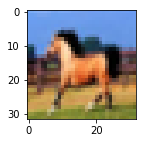

In [16]:
labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
sample = 1902 
each = x_train[sample]

plt.figure(figsize=(2,2))
plt.imshow(each, interpolation='nearest')
print("Image (#{}): Which is label number '{}', or label '{}''".format(sample,y_train[sample], labelNames[y_train[sample][0]]))

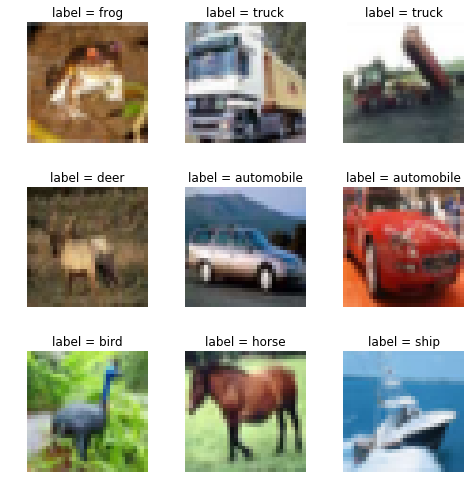

In [37]:
ROW = 3
COLUMN = 3
plt.figure(figsize=(7, 7)) 
for i in range(ROW * COLUMN):
    image = x_train[i] 
    plt.subplot(ROW, COLUMN, i+1)       
    plt.imshow(image, interpolation='nearest')  
    plt.title('label = {}'.format(labelNames[y_train[i][0]]))
    plt.axis('off')
    plt.tight_layout()   
    
plt.show()